In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from tools import *

%matplotlib inline

In [2]:
with open('results/results.json', 'r') as infile:
    raw_results = json.load(infile)
results = list_of_dicts_to_dict_of_lists(raw_results)
for key, value in results.items():
    results[key] = to_nested_tuples(value)
results = pd.DataFrame(data=results)
masks = pd.read_csv('mnist_masks.csv')

In [3]:
rdf = results.copy(deep=True)
rdf = rdf[rdf['success']]
rdf = rdf[rdf['tolerance'] == 2500]
rdf['total_time'] = [sum(row['phase_length']) for _, row in rdf.iterrows()]
for i in rdf.index:
    if (rdf.at[i, 'optimizer'] == 'sgd') and (rdf.at[i, 'momentum'] != '0.0'):
        rdf.at[i, 'optimizer'] = 'momentum'

In [4]:
summary = summarize_results(rdf)
best = get_best(summary)
only_best = only_best_results(rdf, best)

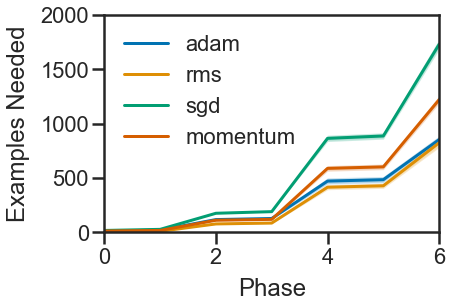

In [7]:
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(settings.phases)),
        stats['phases_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(settings.phases)),
        stats['phases_avg'] - stats['phases_sem'],
        stats['phases_avg'] + stats['phases_sem'],
        alpha=0.3)
plt.legend(frameon=False)
plt.xticks([0, 2, 4, 6])
plt.xlim(0, 6)
plt.xlabel('Phase', labelpad=10)
plt.ylim(0, 2000)
plt.ylabel('Examples Needed', labelpad=10)
plt.savefig('results.pdf')

In [6]:
a = len(results[(results['optimizer'] == 'sgd') & (results['momentum'] == '0.0') & (results['tolerance'] == 2500) & results['success']])
b = len(results[(results['optimizer'] == 'sgd') & (results['momentum'] == '0.0') & (results['tolerance'] == 2500)])
print("SGD: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
a = len(results[(results['optimizer'] == 'sgd') & (results['momentum'] != '0.0') & (results['tolerance'] == 2500) & results['success']])
b = len(results[(results['optimizer'] == 'sgd') & (results['momentum'] != '0.0') & (results['tolerance'] == 2500)])
print("SGD with Momentum: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
a = len(results[(results['optimizer'] == 'rms') & (results['tolerance'] == 2500) & results['success']])
b = len(results[(results['optimizer'] == 'rms') & (results['tolerance'] == 2500)])
print("RMSProp: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
a = len(results[(results['optimizer'] == 'adam') & (results['tolerance'] == 2500) & results['success']])
b = len(results[(results['optimizer'] == 'adam') & (results['tolerance'] == 2500)])
print("Adam: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))

SGD: 52 / 300 (17.33%)
SGD with Momentum: 105 / 900 (11.67%)
RMSProp: 265 / 900 (29.44%)
Adam: 559 / 2700 (20.70%)
